In [1]:
#! pip install segmentation-models
# Import libraries
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
#from time import time
import pandas as pd
import numpy as np
import os 
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

%env SM_FRAMEWORK=tf.keras
import segmentation_models
#print(segmentation_models.__version__)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model, load_model
import tensorflow as tf
#from tensorflow.python.keras.callbacks import TensorBoard
#from keras.callbacks import ModelCheckpoint
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
from rle import mask2rle, rle2mask, area
from model_metric import dice_coef, recall_m, precision_m, f1_score_m
from mask_img import rle_to_mask, build_mask, mask_to_contours, visualise_mask

In [3]:
input_folder = '../Input/'
print('Input folder check', os.listdir(input_folder),'\n')
output_folder = '../Output/'
print('Output folder check', os.listdir(output_folder),'\n')
model_folder = '../Model/'
print('Model folder check', os.listdir(model_folder),'\n')
archieve_folder = '../Output/archive/'
print('Archive folder check', os.listdir(archieve_folder),'\n')

Input folder check ['0abfbfc69.jpg', '0ac9936af.jpg'] 

Output folder check ['.ipynb_checkpoints', 'archive'] 

Model folder check ['.ipynb_checkpoints', 'Defect_model.h5', 'Defect_type1_model.h5', 'Defect_type2_model.h5', 'Defect_type3_model.h5', 'Defect_type4_model.h5'] 

Archive folder check ['.ipynb_checkpoints'] 



In [4]:
def data_prep(input_folder):

    #read all file from train_folder
    img_files = os.listdir(input_folder)
    file_list = []

    if len(img_files)>0:
        print('Number of new image files detected:', len(img_files))
        print('List of image file', img_files)
        
        for file in img_files:
            
            file_list.append(file)
            output_df = pd.DataFrame(file_list, columns = ['ImageId'])
            
        return(output_df)
        
    else:
        print('No file inside input folder')

In [5]:
X = data_prep(input_folder)

Number of new image files detected: 2
List of image file ['0abfbfc69.jpg', '0ac9936af.jpg']


In [6]:
class img_array_gen(keras.utils.Sequence):
    
    def __init__(self, df, batch_size = 1, image_path = input_folder, preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = image_path
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        
    def __getitem__(self, index): 
        '''
        The DataGenerator takes ImageIds of batch size 1 and returns Image array to the model.
        With the help of ImageIds the DataGenerator locates the Image file in the path, the image is read and resized from
        256x1600 to 256x800.
        '''
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))      
        if self.preprocess!=None: X = self.preprocess(X)
            
        return X

In [9]:
def defect_prediction(df, model_path=model_folder):
       
    dependencies = {
                    'recall_m':recall_m,
                    'precision_m':precision_m,
                    'dice_coef':dice_coef,
                    'f1_score_m':f1_score_m,
                    'dice_loss':sm.losses.dice_loss
                   }

    def class_pred(df):
        '''
        Input: ImageIds in form of a dataframe
        Return: Predictions of classification models
        '''
        defect_model = load_model(model_path + 'Defect_model.h5', custom_objects=dependencies)
        df = df.reset_index().drop('index',axis=1)
        img_file = ImageDataGenerator(rescale=1./255).flow_from_dataframe(dataframe=df, 
                                                                          directory='../Input/', 
                                                                          x_col="ImageId", 
                                                                          class_mode = None, 
                                                                          target_size=(256,512), 
                                                                          batch_size=1, 
                                                                          shuffle=False)

        defect_pred = defect_model.predict(img_file, verbose=0)
        defect_status = pd.DataFrame(defect_pred, columns = ['hasDefect'])
        defect_status['hasDefect'] = np.where(defect_pred>0.6,1,0)
        defect_status['ImageId'] = df['ImageId']
        return defect_status[['ImageId', 'hasDefect']]

    def seg_pred(df):
        '''
        Input: ImageIds in form of a dataframe
        Return: Predictions of segmentation models
        '''
        type1_model = load_model(model_path + 'Defect_type1_model.h5', custom_objects=dependencies)
        type2_model = load_model(model_path + 'Defect_type2_model.h5', custom_objects=dependencies)
        type3_model = load_model(model_path + 'Defect_type3_model.h5', custom_objects=dependencies)
        type4_model = load_model(model_path + 'Defect_type4_model.h5', custom_objects=dependencies)
        df = df.reset_index().drop('index',axis=1)
        preprocess = get_preprocessing('efficientnetb1')
        tmp=[]
        loop_num = 50

        for j in range((len(df)//loop_num)+1):
            img_seg = df[loop_num*j:loop_num*j+loop_num]
            img_array =  img_array_gen(img_seg, preprocess=preprocess)
            model1_pred = type1_model.predict(img_array,verbose=0)
            model2_pred = type2_model.predict(img_array,verbose=0)
            model3_pred = type3_model.predict(img_array,verbose=0)
            model4_pred = type4_model.predict(img_array,verbose=0)

            for i in range(len(model1_pred)):
                type1 = mask2rle(np.array((Image.fromarray((model1_pred[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
                type2 = mask2rle(np.array((Image.fromarray((model2_pred[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
                type3 = mask2rle(np.array((Image.fromarray((model3_pred[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
                type4 = mask2rle(np.array((Image.fromarray((model4_pred[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))

                tmp.append([img_seg.ImageId.iloc[i],type1,type2,type3,type4])

        seg_df = pd.DataFrame(tmp,columns=['ImageId','EncodedPixels_1','EncodedPixels_2','EncodedPixels_3','EncodedPixels_4'])            

        return(seg_df)

    def comb_pred(df):
        '''
        Input: ImageId (dataframe)
        Return: Comdined dataframe of output of pred_classification function and pred_segmentation function
        '''
        df = df.reset_index().drop('index',axis=1)
        merge_df = class_pred(df).merge(seg_pred(df),on=['ImageId'])

        def_list = ['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4']

        for defect, i in zip(def_list, (range(1,5))):

            merge_df[defect] = merge_df['EncodedPixels_{}'.format(i)].str.count(' ')
            merge_df['Defect_{}'.format(i)] = (np.where((merge_df['Defect_{}'.format(i)]>0),i,0))

        merge_df[def_list] = merge_df[def_list].replace(0,'')
        merge_df['Defect_Type'] = merge_df.filter(regex='Defect_[1-4]').astype(str).apply(lambda x: x.str.cat(), axis=1)
        merge_df['Defect_Class'] = ""
        defect_list = []
        
        for i in range (len(merge_df['Defect_Type'])):
            defect_list.append([int(digit) for digit in str(merge_df['Defect_Type'][i])])
            for j in range(len(merge_df['Defect_Type'])):
                merge_df['Defect_Class'][i] = defect_list[i]
        merge_df = merge_df.drop(columns=def_list + ['Defect_Type'])

        return merge_df    
    
    pred_output = comb_pred(df)
    
    return pred_output

In [16]:
pred_X = defect_prediction(X)

Found 2 validated image filenames.


In [12]:
def segmentation_pred(df):
    '''
    Function-1:
    Input: ImageId(dataframe)
    Process: Calls pred_combined which calls pred_classification and pred_segmentation
            Applies thresholds -> area and classification probability
    Return: DataFrame (columns = ImageId_ClassId,EncodedPixels)
    
    '''
    df = df.drop(columns=['Defect_Class'])
    df = df.reset_index().drop('index',axis=1)

    tmp = []
    for i in range(len(df)):      
        imgid, defect, type1, type2, type3, type4 = df.iloc[i]  
        # j, b, m1, m2, m3, m4, ep1, ep2, ep3, ep4 = p.iloc[i]
        # randomly selected classification threshold values to get high recall 
        # for no defect binary classifier and high precision for multi-label classifier 
        # while not compromising much on other metrics
        
        # area thresholds are determined from EDA performed only on train dataset
        if area(type1)>=500 and area(type1)<=15500 and defect>=0.95: 
            tmp.append([imgid+'_1',type1])
        else:
            tmp.append([imgid+'_1',''])

        if area(type2)>=700 and area(type2)<=10000 and defect>=0.855:
            tmp.append([imgid+'_2',type2])
        else:
            tmp.append([imgid+'_2',''])

        if area(type3)>=1100 and area(type3)<=160000 and defect>=0.85:
            tmp.append([imgid+'_3',type3])
        else:
            tmp.append([imgid+'_3',''])
            
        if area(type4)>=2800 and area(type4)<=127000 and defect>=0.85:
            tmp.append([imgid+'_4',type4])
        else:
            tmp.append([imgid+'_4',''])
            
    return pd.DataFrame(tmp, columns = ['ImageId_ClassId','EncodedPixels'])

In [13]:
seg_df = segmentation_pred(pred_X)

In [14]:
def post_processing(df, seg_df, input_path, output_path):
    
    seg_df['ImageId'] = seg_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
    seg_df['ClassId'] = seg_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
    seg_df['ClassId'] = seg_df['ClassId'].astype(np.uint8)

    def img_report(df):

        col_name = ['Timestamp', 'ImageId', 'hasDefect', 'Defect_Class']

        dateTimeObj = datetime.now()
        timestampStr = dateTimeObj.strftime("%d-%b-%Y %H:%M:%S")
        print('Current Timestamp : ', timestampStr)

        df['Timestamp'] = timestampStr
        df = df[col_name].copy()

        while True:

            try:
                record = pd.read_csv(output_folder + 'defect_report.csv')           
                print('Read record from defect_report.csv')  

                record_img = list(record['ImageId'])
                new_img = list(df['ImageId'])

                for img in new_img:
                    if img in record_img:
                        print(img,'found in previous record')

                #remove row if record already found in report
                df = df[~df['ImageId'].isin(record_img)]
                record = record.append(df)
                record.to_csv(output_folder + 'defect_report.csv', index=False)

                if len(df)<1:
                    print('No data to update')
                else:
                    print('Report updated with latest data')

                return

            except FileNotFoundError:
                print('defect_report.csv not found in folder')
                new_df = pd.DataFrame(columns = col_name)
                new_df = new_df.append(df)
                new_df.to_csv(output_folder + 'defect_report.csv', index=False)
                print('Created defect_report.csv with latest data')

                break

    def archive_img():
        
        record = pd.read_csv(output_folder + 'defect_report.csv')           
        record_img = list(record['ImageId'])
                
        for top, dirs, files in os.walk(input_folder):
            for filename in files:
                if not filename.endswith('.jpg'):
                    continue
                file_path = os.path.join(top, filename)
                if filename in record_img:
                    shutil.move(file_path, os.path.join(archieve_folder, filename))    
        
        print('Scoring completed, image file(s) moved to archieve folder')
        
    def generate_masked_images(preds, input_path, output_path):

        preds.replace("", float("NaN"), inplace=True)
        preds.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)
        preds = preds[['ImageId', 'EncodedPixels', 'ClassId']].groupby('ImageId', as_index=False).agg(list)
        preds['image_id'] = preds['ImageId'].apply(lambda x: x.split('.')[0])
        plt.figure(figsize=(20,10))

        for i, (index, row) in enumerate(preds.iterrows()):    
            # build the mask
            mask = build_mask(encodings=row.EncodedPixels, labels=row.ClassId)

            # fetch the image and draw the contours
            print('filename', row.ImageId)
            image = visualise_mask(file_name=row.ImageId, mask=mask, img_folder=input_path)

            # display
            plt.title(row.ImageId)
            #ax.axis('off')
            plt.imshow(image);
            plt.savefig(output_path + '{}_defect.png'.format(row.image_id))

        print('Defect image(s) saved to output folder')

    img_report(df)
    generate_masked_images(seg_df, input_path, output_path)
    #archive_img()    

Current Timestamp :  19-Oct-2020 18:24:57
defect_report.csv not found in folder
Created defect_report.csv with latest data
filename 0abfbfc69.jpg
filename 0ac9936af.jpg
Defect image(s) saved to output folder


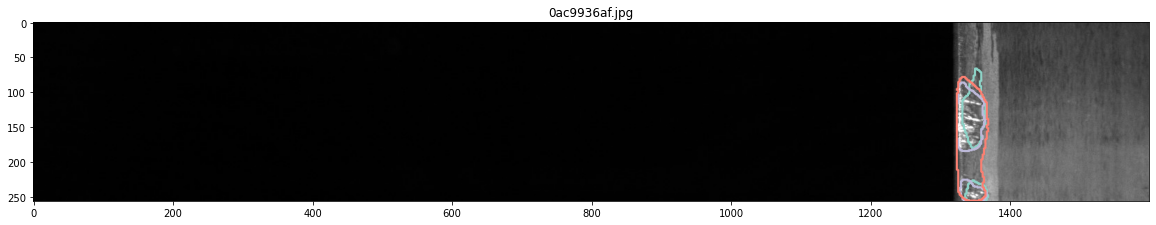

In [15]:
post_processing(pred_X, seg_df, input_folder, output_folder)